#            Mnist using numpy



In [0]:
import sys
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
np.random.seed(1)


###1.1 Data Loading: (method : data_prep())
  The mnist dataset is loaded from the keras datasets, the train and test data are seperated. One hot encoding is done fo the train and test labels in the same function.

In [0]:
def data_prep(x_train, y_train, x_test, y_test):
  #images, labels = (x_train[0:1000].reshape(1000, 28*28)/ 255, y_train[0:1000])
  images, labels = (x_train.reshape(len(x_train), 28*28)/ 255, y_train)
  one_hot_labels = np.zeros((len(labels), 10))
  for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
  labels = one_hot_labels
  test_images = x_test.reshape(len(x_test), 28*28)/255
  test_labels = np.zeros((len(y_test), 10))
  for i, l in enumerate(y_test):
    test_labels[i][l] = 1
  return (images, labels, test_images, test_labels)

###1.2 Activation functions:
  Activation functions RELU, RELU2Deriv and softmax activations functions are defined.

In [0]:
relu = lambda x: (x>=0) * x
relu2derive = lambda x: x>=0
def softmax(x):
  temp = np.exp(x)
  return temp/np.sum(temp, axis=1, keepdims=True)

###1.3 Preview of images:

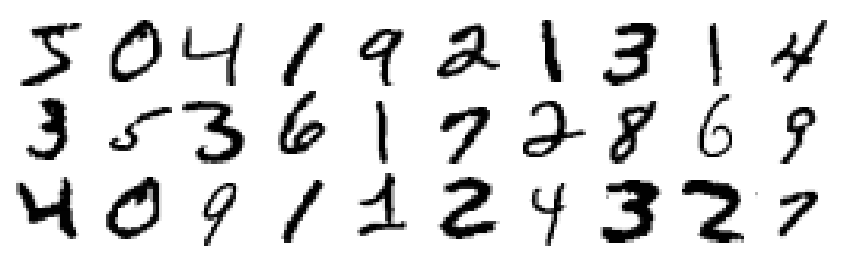

In [152]:
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(images[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

#2. Class Simple Neural Network(SNN):
  The class takes the basic parameters like images, alpha value, number of epochs, labels, and boolean dropout
###2.1 Weights Initialization:
  Intial weights for each layer is defined, random values are choosen to initialize the weights.
###2.2 Activation Function:
  Relu and softmax activation functions are called for each layer respectively and dropout is also applied in this function

###2.3 Forward propogation function:
  activation for each layer is calculated.
###2.4 Backpropogation function:
  The gradient is calculated for each layer. 
###2.5 Weight updation:
  The new weights for each layer is calculated with respect to the gradient calculated earlier. Different alpha value is used in each epoc for weights calculations.
###2.6 Image augmentation:
  The image augmentation is done by rotating, zooming, shifting the width and shifting the height.
###2.7 Train Images:
  10 iterations are implemented to train the model with a total images of 60k images with a batch size of 130 in each batch. The resulting weights used for the validation of test images.
###2.8 Confusion Matrix Plot:
  Confusion matrix is plotted using the predicted values from the model.
###2.8 Predict model:
  The resulting weights are applied on the layers resulting in a test accuracy 87%

In [0]:
#Class Simple Neural Network(SNN):
class SNNetwork:
  def __init__(self, images, batch_size, alpha, iterations, layers, labels,drop_out):
    self.images = images
    self.batch_size = batch_size
    self.alpha = alpha
    self.iterations = iterations
    self.layers = layers
    self.labels = labels
    self.drop_out = drop_out

#Weights Initialization:    
  def ini_weights(self):
    weights = [None] * (len(self.layers)-1)
    a = [0.204, 0.215, 0.22, 0.328]
    #a = [0.228, 0.210, 0.205, 0.328]
    for i in range(len(self.layers)-1):
      weights[i] = a[i] * np.random.random((self.layers[i], self.layers[i+1])) -0.1
    return weights

#Activation Function:
  def activation(self,l, w,d):
    layer = np.dot(l,w)
    relu(layer)
    if(self.drop_out == True and d==0):
      dropout_mask = np.random.randint(2, size = layer.shape)
      layer *= dropout_mask * 2
    return layer
    
#Forward propogation function: 
  def forward_prop(self, layer_in, weights):
    ec_layer = []
    next_layer = [None] * (len(self.layers)-2)
    
    ec_layer.append(layer_in)
    for i in range(len(self.layers)-2):
      d = i
      next_layer[i] = self.activation(ec_layer[i], weights[i], d)
      ec_layer.append(next_layer[i])
    layer_out = softmax(np.dot(ec_layer[-1], weights[-1]))
    ec_layer.append(layer_out)
    return ec_layer

#Backpropogation function:
  def back_prop(self, each_layer, batch_start, batch_end, weights):
    grad = []
    delta = [None] * (len(self.layers)-2)
    op_delta = (self.labels[batch_start:batch_end] - each_layer[-1])/self.batch_size
    temp = op_delta
    for i in range(1,len(each_layer)-1):
      delta[-i] = op_delta.dot(weights[-i].T) * relu2derive(each_layer[-i-1])
      op_delta = delta[-i]
    
    for j in range(len(delta)):
      grad.append(delta[j])
    grad.append(temp)
    return grad
  
#Weight updation:
  def weights_up(self, gradients, each_layer,weights, alpha):
    for i in range(len(weights)):
      weights[i] = weights[i] + self.alpha*np.dot(each_layer[i].T, gradients[i])
    return weights

#Image augmentation:
  def imageAug(self, images):
  
    images = images.reshape(-1,28,28,1)
    datagen = ImageDataGenerator(
              rotation_range=10,  
              zoom_range = 0.50,  
              width_shift_range=0.1, 
              height_shift_range=0.1)


    datagen.fit(images)
    batches = datagen.flow(images, batch_size = len(images))
    x_batch = next(batches)
    x_batch = x_batch.reshape(len(images), 28*28)
    return x_batch
  
#Confusion Matrix plot:
  def plot_confusion_matrix(self, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

 #Train Images:     
  def train_net(self,weights):
    alpha = self.alpha
    train_loss, train_acc = (0.0, 0)
    aug_images = self.images
    for i in range(int(len(aug_images)/self.batch_size)):
      batch_start, batch_end = (i*self.batch_size, (i+1)*self.batch_size)
      layer_in = aug_images[batch_start:batch_end]
      each_layer = self.forward_prop(layer_in, weights)
      train_loss += np.sum((each_layer[-1] - self.labels[batch_start:batch_end]) **2)
      for k in range(self.batch_size):
        train_acc += int(np.argmax(each_layer[-1][k:k+1]) == np.argmax(self.labels[batch_start+k:batch_start+k+1]))

        gradients = self.back_prop(each_layer, batch_start, batch_end, weights)
        weights = self.weights_up(gradients,each_layer, weights, alpha)
    
    alpha = alpha + 0.000005
    
    # if(acc>temp):
    #   temp = acc
    #   g_weights = weights
    return (train_loss, train_acc, weights)

#Predict model:
  def nn_fit(self,test_images, test_labels):
    images = self.images
    print(images.shape)
    weights = self.ini_weights()
    tr_loss = []
    tes_loss = []
    for j in range(self.iterations):
      y_pred = []
      test_error, test_cnt = (0.0, 0)
      train_loss,train_acc,weights = self.train_net(weights)

      for i in range(len(test_images)):
        layer_in = test_images[i:i+1]
        each_layer = self.forward_prop(layer_in, weights)
        y = each_layer[-1]
        y_pred.append(y)

        test_error += np.sum((test_labels[i:i+1] - each_layer[-1]) **2)
        test_cnt += int(np.argmax(each_layer[-1]) == np.argmax(test_labels[i:i+1]))

      #tr = train_acc/float(len(images))
      #ts = test_cnt/float(len(test_images))
      tr_loss.append(train_loss/float(len(images)))
      tes_loss.append(test_error/float(len(test_images)))  
      print("Epoch",str(j)," train_loss:" + str(train_loss/float(len(images)))[0:5], \
            "Train accuracy:",format((train_acc/float(len(images))),'.4f'),\
            "Validation_loss:" + str(test_error/float(len(test_images)))[0:5], \
            "Val accuracy:",format((test_cnt/float(len(test_images))), '.4f'))
    
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(10000,10)
    return y_pred, tr_loss, tes_loss

#Plot the graph
  def plot_validation(self, tr_loss, tes_loss):
    epoch_count = range(1, len(tr_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, tr_loss, 'r--')
    plt.plot(epoch_count, tes_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

#plot the missed predictions
  def display_errors(self,errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("\nPredicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()
    
      


##3. Main 
#3.1 Initialize Model:
  The model is initialized with 3 hidden layers and defining the neurons in each layer.

(60000, 784)
Epoch 0  train_loss:0.360 Train accuracy: 0.7464 Validation_loss:0.243 Val accuracy: 0.8321
Epoch 1  train_loss:0.228 Train accuracy: 0.8454 Validation_loss:0.216 Val accuracy: 0.8514
Epoch 2  train_loss:0.208 Train accuracy: 0.8599 Validation_loss:0.197 Val accuracy: 0.8650
Epoch 3  train_loss:0.197 Train accuracy: 0.8678 Validation_loss:0.190 Val accuracy: 0.8719
Epoch 4  train_loss:0.192 Train accuracy: 0.8710 Validation_loss:0.185 Val accuracy: 0.8780
Epoch 5  train_loss:0.187 Train accuracy: 0.8752 Validation_loss:0.183 Val accuracy: 0.8760
Epoch 6  train_loss:0.185 Train accuracy: 0.8763 Validation_loss:0.180 Val accuracy: 0.8806
Epoch 7  train_loss:0.185 Train accuracy: 0.8765 Validation_loss:0.182 Val accuracy: 0.8773
Epoch 8  train_loss:0.183 Train accuracy: 0.8771 Validation_loss:0.183 Val accuracy: 0.8755
Epoch 9  train_loss:0.183 Train accuracy: 0.8786 Validation_loss:0.192 Val accuracy: 0.8682


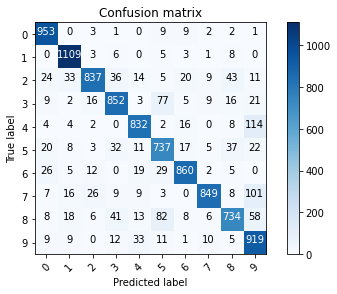

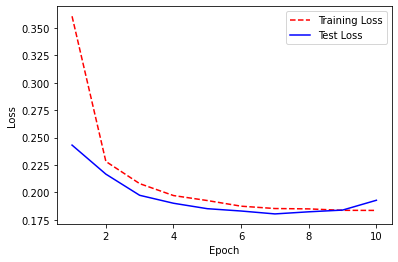

In [154]:
image_pixel, num_labels = (784,10)
hidden_layers = [256,192]
layer_size = [image_pixel]
for i in range(len(hidden_layers)):
  layer_size.append(hidden_layers[i])
layer_size.append(num_labels)

(x_train, y_train) , (x_test, y_test) = mnist.load_data()
images, labels, test_images, test_labels = data_prep(x_train, y_train, x_test, y_test)
np.random.seed(1)

#Initialize Model:
model = SNNetwork(images=images, batch_size=100, alpha = 0.000224, iterations=10, layers=layer_size, labels=labels, drop_out=True )
y_pred, tr_loss, tes_loss = model.nn_fit(test_images, test_labels)

Y_pred_classes = np.argmax(y_pred,axis =1) 
Y_true = np.argmax(test_labels,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
model.plot_confusion_matrix(confusion_mtx, classes = range(10))
model.plot_validation(tr_loss, tes_loss)

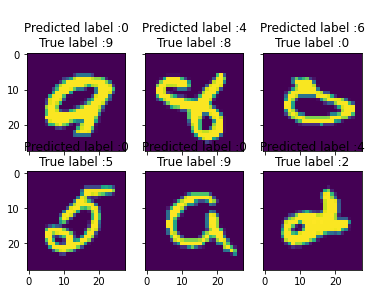

In [155]:
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = test_images[errors]

Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-6:]
model.display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)